# Load Reviewed Theses to Neo4j

This notebook:
1. Reads `thesis_reviewed.csv` from the data/analysis folder
2. Creates Thesis nodes in Neo4j with all properties
3. Generates embeddings for thesis descriptions
4. Creates core thesis nodes from unique core_thesis values
5. Creates SUPPORTS relationships: each thesis → its core thesis

**Schema:**
- Thesis Node: thesis, node_num, description, description_embedding, core_thesis, created, updated
- Relationships: Thesis -[:SUPPORTS]-> CoreThesis


In [43]:
import os
import pandas as pd
from pathlib import Path
from typing import List, Dict, Any
from datetime import datetime
from openai import OpenAI
from neo4j import GraphDatabase
from dotenv import load_dotenv

# Load environment variables
env_path = Path("../.env").resolve()
load_dotenv(env_path)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "password")

# Initialize clients
openai_client = OpenAI(api_key=OPENAI_API_KEY) if OPENAI_API_KEY else None

# Initialize Neo4j driver and test connection
neo4j_driver = None
if NEO4J_URI:
    try:
        neo4j_driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
        neo4j_driver.verify_connectivity()
        print(f"✓ Configuration loaded")
        print(f"  OpenAI client: {'✓' if openai_client else '✗'}")
        print(f"  Neo4j driver: ✓ Connected to {NEO4J_URI}")
    except Exception as e:
        print(f"✓ Configuration loaded")
        print(f"  OpenAI client: {'✓' if openai_client else '✗'}")
        print(f"  Neo4j driver: ✗ Connection failed")
        print(f"  Error: {type(e).__name__}: {str(e)[:100]}")
        neo4j_driver = None
else:
    print(f"✓ Configuration loaded")
    print(f"  OpenAI client: {'✓' if openai_client else '✗'}")
    print(f"  Neo4j driver: ✗ (NEO4J_URI not set)")

# File paths
CSV_FILE = Path("../data/analysis/theses_reviewed.csv")
print(f"\n  CSV file: {CSV_FILE.absolute()}")
print(f"  CSV exists: {CSV_FILE.exists()}")


✓ Configuration loaded
  OpenAI client: ✓
  Neo4j driver: ✓ Connected to neo4j+s://be06b044.databases.neo4j.io

  CSV file: C:\Users\ChetKumar\Projects\thesis-bot\notebooks\..\data\analysis\theses_reviewed.csv
  CSV exists: True


In [44]:
# Step 1: Load and validate the CSV file

if not CSV_FILE.exists():
    print(f"⚠ Error: {CSV_FILE} not found!")
    print(f"  Please ensure you have reviewed and saved the CSV as 'thesis_reviewed.csv'")
else:
    df = pd.read_csv(CSV_FILE)
    print(f"✓ Loaded CSV: {len(df)} rows")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Validate required columns
    required_columns = ["Thesis Number", "Thesis Statement", "Description"]
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"\n⚠ Warning: Missing columns: {missing_columns}")
    else:
        print(f"\n✓ All required columns present")


✓ Loaded CSV: 19 rows

Columns: ['Thesis Number', 'Thesis Statement', 'Description', 'Supports Thesis Numbers', 'Core Thesis', 'Source File']

First few rows:
   Thesis Number                                   Thesis Statement  \
0              1  Generative AI's true impact is still in its ea...   
1              2  Enterprises adopting verticalized approaches w...   
2              3  Hybrid, human-in-the-loop AI systems will rema...   
3              4  Inference demand is reshaping compute requirem...   
4              5  Agentic AI systems will require new infrastruc...   

                                         Description Supports Thesis Numbers  \
0  The full potential of generative AI has yet to...                       2   
1  Businesses that tailor AI solutions to specifi...                     NaN   
2  Despite advances in AI, systems that incorpora...                       5   
3  As the use of AI models grows, the demand for ...                       5   
4  For AI syst

In [45]:
# Step 2: Generate 4-word thesis titles using OpenAI

def generate_4word_title(thesis_statement: str) -> str:
    """Generate a tight 4-word summary title for a thesis statement using OpenAI."""
    if not openai_client:
        return thesis_statement[:50]  # Fallback to truncated original
    
    prompt = f"""Generate a concise, tight 4-word title that summarizes the following thesis statement.

Requirements:
- Exactly 4 words (no more, no less)
- Capture the core essence of the thesis
- Be specific and meaningful
- Use title case (capitalize important words)

Thesis statement: "{thesis_statement}"

Return ONLY the 4-word title, nothing else."""

    try:
        response = openai_client.chat.completions.create(
            model="gpt-4o-mini",  # Fast and cost-effective for this task
            messages=[
                {"role": "system", "content": "You are an expert at creating concise, impactful titles. Always return exactly 4 words."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=20
        )
        
        title = response.choices[0].message.content.strip()
        # Clean up any quotes or extra text
        title = title.strip('"').strip("'").strip()
        
        # Validate it's approximately 4 words (allow some flexibility for edge cases)
        word_count = len(title.split())
        if word_count < 3 or word_count > 5:
            print(f"    ⚠ Warning: Generated title has {word_count} words: '{title}'")
        
        return title
    except Exception as e:
        print(f"    ⚠ Error generating title: {e}")
        return thesis_statement[:50]  # Fallback

# Generate 4-word titles for all theses
print("Generating 4-word thesis titles...")
thesis_titles = {}
for idx, row in df.iterrows():
    thesis_num = row.get("Thesis Number", idx + 1)
    thesis_statement = str(row.get("Thesis Statement", "")).strip()
    
    if thesis_statement and thesis_statement != "nan":
        print(f"  Generating title for thesis {thesis_num}...")
        title = generate_4word_title(thesis_statement)
        thesis_titles[thesis_num] = title
        print(f"    ✓ '{title}'")
    else:
        print(f"  ⚠ Thesis {thesis_num} has no statement, skipping title generation")

print(f"\n✓ Generated {len(thesis_titles)} 4-word titles")

# Add titles to dataframe for reference
df['Title'] = df['Thesis Number'].map(thesis_titles)
print(f"\nSample titles:")
for idx, row in df.head(5).iterrows():
    if pd.notna(row.get('Title')):
        print(f"  #{row.get('Thesis Number')}: {row.get('Title')}")


Generating 4-word thesis titles...
  Generating title for thesis 1...
    ✓ 'Emerging Impact of Generative AI'
  Generating title for thesis 2...
    ✓ 'Verticalized Approaches Enhance Solutions'
  Generating title for thesis 3...
    ✓ 'Hybrid AI: Enterprise Strategy Essential'
  Generating title for thesis 4...
    ✓ 'Reshaping Compute Infrastructure Demand'
  Generating title for thesis 5...
    ✓ 'Scaling Agentic AI Infrastructure'
  Generating title for thesis 6...
    ✓ 'AI Business Models: Risks, Rewards'
  Generating title for thesis 7...
    ✓ 'Trapped By Localized Challenges'
  Generating title for thesis 8...
    ✓ 'Accelerating Drug Development Revolution'
  Generating title for thesis 9...
    ✓ 'Accelerating Drug Discovery Technologies'
  Generating title for thesis 10...
    ✓ 'Digital Health Interoperability Transformation'
  Generating title for thesis 11...
    ✓ 'Tech-Enabled Drug Discovery Revolution'
  Generating title for thesis 12...
    ✓ 'Interoperability Enhan

In [46]:
# Step 3: Generate embeddings for thesis descriptions

def generate_embedding(text: str) -> List[float]:
    """Generate embedding for text using OpenAI's embedding model."""
    if not openai_client:
        return []
    try:
        response = openai_client.embeddings.create(
            model="text-embedding-3-small",
            input=text
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return []

# Generate embeddings for all theses
print("Generating embeddings for thesis descriptions...")
embeddings = {}
for idx, row in df.iterrows():
    thesis_num = row.get("Thesis Number", idx + 1)
    description = str(row.get("Description", ""))
    
    if description and description != "nan":
        print(f"  Generating embedding for thesis {thesis_num}...")
        embedding = generate_embedding(description)
        embeddings[thesis_num] = embedding
        if embedding:
            print(f"    ✓ Generated {len(embedding)}-dimensional embedding")
        else:
            print(f"    ✗ Failed to generate embedding")
    else:
        print(f"  ⚠ Thesis {thesis_num} has no description, skipping embedding")

print(f"\n✓ Generated {len(embeddings)} embeddings")


Generating embeddings for thesis descriptions...
  Generating embedding for thesis 1...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 2...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 3...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 4...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 5...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 6...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 7...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 8...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 9...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 10...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 11...
    ✓ Generated 1536-dimensional embedding
  Generating embedding for thesis 12...
    ✓ G

In [47]:
# Step 4: Create Neo4j graph

def clear_neo4j_database(driver):
    """Clear all nodes and relationships from Neo4j."""
    if not driver:
        return
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    print("✓ Cleared Neo4j database")

def create_neo4j_thesis_graph(driver, df: pd.DataFrame, embeddings: Dict[int, List[float]]):
    """
    Create Thesis nodes and relationships in Neo4j from the reviewed CSV.
    
    Schema:
    - Thesis Node: thesis, node_num, description, description_embedding, core_thesis, created, updated
    - CoreThesis Node: core_thesis (the unique core thesis value)
    - Relationship: Thesis -[:SUPPORTS]-> CoreThesis
    """
    if not driver:
        print("⚠ Neo4j driver not configured. Skipping graph creation.")
        return
    
    current_time = datetime.now().isoformat()
    
    with driver.session() as session:
        # Clear existing data
        clear_neo4j_database(driver)
        
        # Step 1: Create CoreThesis nodes from unique core_thesis values
        # First, identify unique core thesis values
        core_thesis_values = set()
        for _, row in df.iterrows():
            core_thesis = row.get("Core Thesis", "").strip()
            if core_thesis and str(core_thesis) != "nan":
                core_thesis_values.add(core_thesis)
        
        print(f"\nCreating {len(core_thesis_values)} CoreThesis nodes...")
        for core_thesis in core_thesis_values:
            session.run(
                """
                MERGE (ct:CoreThesis {core_thesis: $core_thesis})
                SET ct.created = $created,
                    ct.updated = $updated
                """,
                core_thesis=core_thesis,
                created=current_time,
                updated=current_time
            )
        print(f"  ✓ Created {len(core_thesis_values)} CoreThesis nodes")
        
        # Step 2: Create Thesis nodes
        print(f"\nCreating {len(df)} Thesis nodes...")
        node_counter = 0
        for _, row in df.iterrows():
            node_counter += 1
            thesis_num = row.get("Thesis Number", node_counter)
            thesis = str(row.get("Thesis Statement", "")).strip()
            description = str(row.get("Description", "")).strip()
            core_thesis = str(row.get("Core Thesis", "")).strip()
            
            # Skip if thesis is empty
            if not thesis or thesis == "nan":
                print(f"  ⚠ Skipping row {node_counter}: empty thesis statement")
                continue
            
            # Get embedding and title if available
            embedding = embeddings.get(thesis_num, [])
            title = thesis_titles.get(thesis_num, "")
            
            # Check if this thesis statement IS a core thesis (matches a CoreThesis value)
            is_core = thesis in core_thesis_values
            
            # Create Thesis node
            # core_thesis property stores the string value from CSV (which CoreThesis it supports)
            # We'll set a boolean flag separately
            session.run(
                """
                CREATE (t:Thesis {
                    thesis: $thesis,
                    title: $title,
                    node_num: $node_num,
                    description: $description,
                    description_embedding: $embedding,
                    core_thesis: $core_thesis_string,
                    core_thesis_flag: $is_core,
                    created: $created,
                    updated: $updated
                })
                """,
                thesis=thesis,
                title=title,
                node_num=int(thesis_num) if pd.notna(thesis_num) else node_counter,
                description=description if description != "nan" else "",
                embedding=embedding,
                core_thesis_string=core_thesis if core_thesis != "nan" else "",
                is_core=is_core,
                created=current_time,
                updated=current_time
            )
        
        print(f"  ✓ Created {node_counter} Thesis nodes")
        
        # Step 3: Create SUPPORTS relationships: Thesis -> CoreThesis
        print(f"\nCreating SUPPORTS relationships...")
        relationship_count = 0
        for _, row in df.iterrows():
            thesis = str(row.get("Thesis Statement", "")).strip()
            core_thesis = str(row.get("Core Thesis", "")).strip()
            
            if thesis and core_thesis and thesis != "nan" and core_thesis != "nan":
                session.run(
                    """
                    MATCH (t:Thesis {thesis: $thesis})
                    MATCH (ct:CoreThesis {core_thesis: $core_thesis})
                    MERGE (t)-[:SUPPORTS]->(ct)
                    """,
                    thesis=thesis,
                    core_thesis=core_thesis
                )
                relationship_count += 1
        
        print(f"  ✓ Created {relationship_count} SUPPORTS relationships")
        
        # Step 4: Verify core_thesis flags
        # The flags were already set during node creation
        result = session.run(
            """
            MATCH (t:Thesis)
            WHERE t.core_thesis_flag = true
            RETURN count(t) as count
            """
        )
        core_count = result.single()["count"]
        print(f"\n✓ Core thesis flags set: {core_count} theses marked as core_thesis=true")
        
        print(f"\n✓ Neo4j graph created successfully!")
        print(f"  Summary:")
        print(f"    - CoreThesis nodes: {len(core_thesis_values)}")
        print(f"    - Thesis nodes: {node_counter}")
        print(f"    - SUPPORTS relationships: {relationship_count}")

# Create the graph
if CSV_FILE.exists() and neo4j_driver:
    create_neo4j_thesis_graph(neo4j_driver, df, embeddings)
else:
    print("\n⚠ Cannot create graph:")
    if not CSV_FILE.exists():
        print("  - CSV file not found")
    if not neo4j_driver:
        print("  - Neo4j not connected")


✓ Cleared Neo4j database

Creating 3 CoreThesis nodes...
  ✓ Created 3 CoreThesis nodes

Creating 19 Thesis nodes...
  ✓ Created 19 Thesis nodes

Creating SUPPORTS relationships...
  ✓ Created 19 SUPPORTS relationships

✓ Core thesis flags set: 0 theses marked as core_thesis=true

✓ Neo4j graph created successfully!
  Summary:
    - CoreThesis nodes: 3
    - Thesis nodes: 19
    - SUPPORTS relationships: 19


In [48]:
# Step 4: Verify the graph

def query_neo4j_stats(driver):
    """Query Neo4j to get graph statistics."""
    if not driver:
        print("⚠ Neo4j driver not configured.")
        return
    
    with driver.session() as session:
        # Count nodes by label
        result = session.run("""
            MATCH (n)
            RETURN labels(n)[0] as label, count(n) as count
            ORDER BY count DESC
        """)
        print("\nNodes by type:")
        for record in result:
            print(f"  {record['label']}: {record['count']}")
        
        # Count relationships
        result = session.run("""
            MATCH ()-[r]->()
            RETURN type(r) as rel_type, count(r) as count
            ORDER BY count DESC
        """)
        print("\nRelationships by type:")
        for record in result:
            print(f"  {record['rel_type']}: {record['count']}")
        
        # Show some example theses
        result = session.run("""
            MATCH (t:Thesis)
            RETURN t.thesis as thesis, t.core_thesis_flag as core_thesis, t.node_num as node_num
            ORDER BY t.node_num
            LIMIT 10
        """)
        print("\nExample theses (first 10):")
        for record in result:
            core_flag = "✓" if record['core_thesis'] else " "
            print(f"  [{core_flag}] #{record['node_num']}: {record['thesis'][:80]}...")
        
        # Show core thesis relationships
        result = session.run("""
            MATCH (t:Thesis)-[:SUPPORTS]->(ct:CoreThesis)
            RETURN ct.core_thesis as core_thesis, count(t) as thesis_count
            ORDER BY thesis_count DESC
        """)
        print("\nCoreThesis nodes and their supporting theses:")
        for record in result:
            print(f"  '{record['core_thesis']}': {record['thesis_count']} supporting theses")

# Query the graph
if neo4j_driver:
    query_neo4j_stats(neo4j_driver)



Nodes by type:
  Thesis: 19
  CoreThesis: 3

Relationships by type:
  SUPPORTS: 19

Example theses (first 10):
  [ ] #1: Generative AI's true impact is still in its early stages, with second order appl...
  [ ] #2: Enterprises adopting verticalized approaches will build the most practical and d...
  [ ] #3: Hybrid, human-in-the-loop AI systems will remain a core part of enterprise AI st...
  [ ] #4: Inference demand is reshaping compute requirements, necessitating flexible, scal...
  [ ] #5: Agentic AI systems will require new infrastructure and cost-efficient frameworks...
  [ ] #6: AI business models present unique investment challenges and opportunities compar...
  [ ] #7: AI companies using SaaS-style product-led growth playbooks are at high risk of t...
  [ ] #8: Advances in machine learning and data infrastructure are accelerating drug devel...
  [ ] #9: Tech-Enabled Drug Discovery is a field where advanced technologies, such as arti...
  [ ] #10: Digital health interoperability


VISUALIZING GRAPH


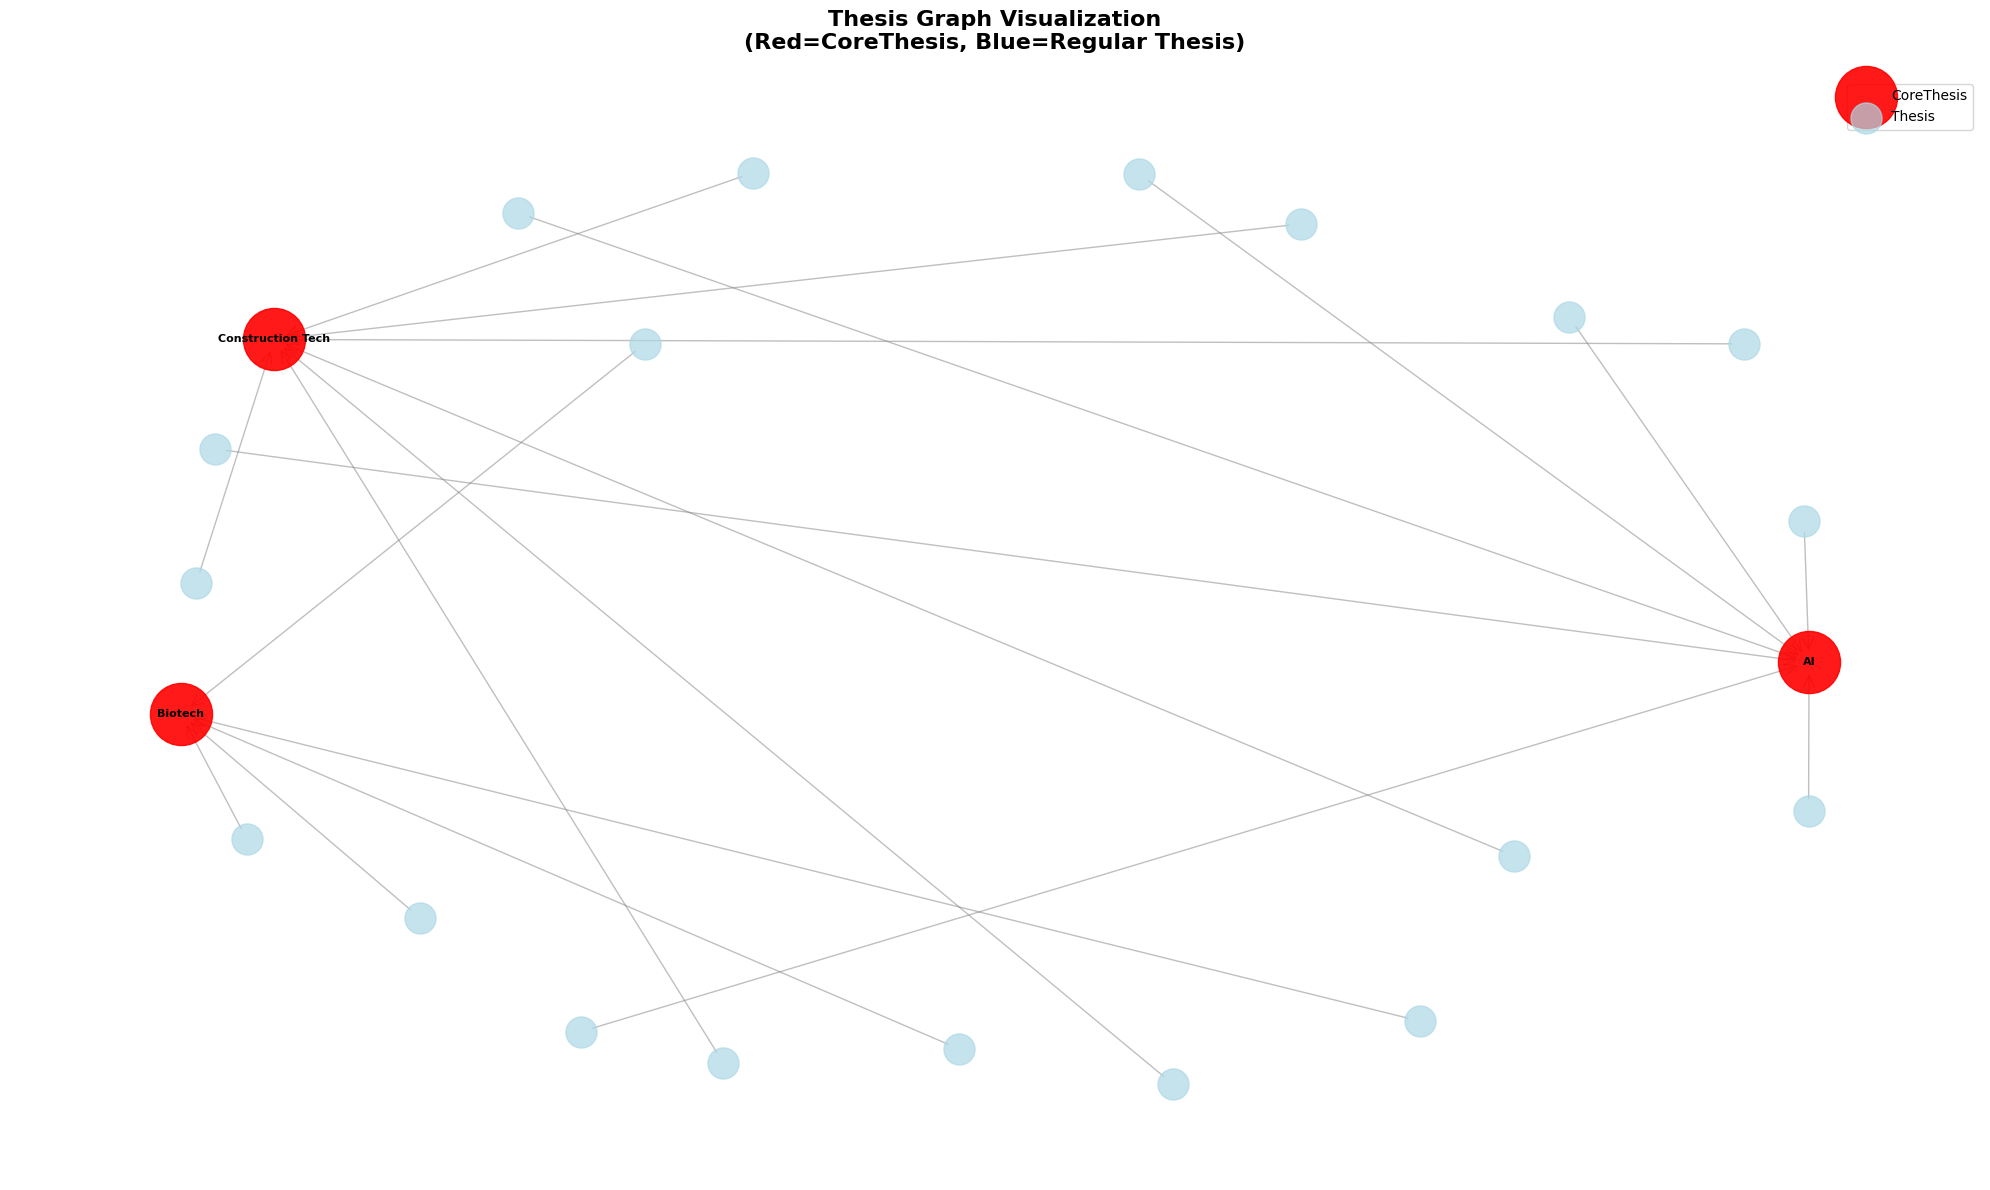


Graph Statistics:
  Total nodes: 22
  Total edges: 19
  CoreThesis nodes: 3
  Core thesis nodes: 0
  Regular thesis nodes: 19


In [49]:
# Step 5: Visualize the graph in the notebook using NetworkX and matplotlib

import networkx as nx
import matplotlib.pyplot as plt

def query_neo4j_for_visualization(driver) -> nx.DiGraph:
    """Query Neo4j and build a NetworkX graph for visualization."""
    if not driver:
        print("⚠ Neo4j driver not configured.")
        return nx.DiGraph()
    
    G = nx.DiGraph()
    
    with driver.session() as session:
        # Get all Thesis nodes
        result = session.run("""
            MATCH (t:Thesis)
            RETURN t.thesis as thesis, t.title as title, t.node_num as node_num, 
                   t.core_thesis_flag as is_core, t.description as description
        """)
        for record in result:
            thesis = record["thesis"]
            node_num = record["node_num"]
            is_core = record["is_core"]
            description = record["description"]
            
            title = record.get("title", "")
            G.add_node(thesis, 
                      node_type="Thesis",
                      title=title if title else "",
                      node_num=node_num,
                      is_core=bool(is_core) if is_core is not None else False,
                      description=description[:100] if description else "")
        
        # Get all CoreThesis nodes
        result = session.run("""
            MATCH (ct:CoreThesis)
            RETURN ct.core_thesis as core_thesis
        """)
        for record in result:
            core_thesis = record["core_thesis"]
            G.add_node(core_thesis, node_type="CoreThesis")
        
        # Get all SUPPORTS relationships
        result = session.run("""
            MATCH (t:Thesis)-[:SUPPORTS]->(ct:CoreThesis)
            RETURN t.thesis as thesis, ct.core_thesis as core_thesis
        """)
        for record in result:
            thesis = record["thesis"]
            core_thesis = record["core_thesis"]
            G.add_edge(thesis, core_thesis, relationship="SUPPORTS")
    
    return G

def visualize_graph_matplotlib(G: nx.DiGraph, figsize=(20, 12)):
    """Visualize the graph using matplotlib."""
    if G.number_of_nodes() == 0:
        print("⚠ No nodes to visualize")
        return
    
    plt.figure(figsize=figsize)
    
    # Separate nodes by type
    thesis_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "Thesis"]
    core_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "CoreThesis"]
    core_thesis_nodes = [n for n in thesis_nodes if G.nodes[n].get("is_core", False)]
    
    # Use hierarchical layout for better visualization
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Draw CoreThesis nodes (large, red)
    if core_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, 
                              node_color='red', node_size=2000, 
                              alpha=0.9, label='CoreThesis')
    
    # Draw core thesis nodes (medium, orange)
    if core_thesis_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=core_thesis_nodes,
                              node_color='orange', node_size=1000,
                              alpha=0.8, label='Core Thesis')
    
    # Draw regular thesis nodes (small, blue)
    regular_thesis = [n for n in thesis_nodes if n not in core_thesis_nodes]
    if regular_thesis:
        nx.draw_networkx_nodes(G, pos, nodelist=regular_thesis,
                              node_color='lightblue', node_size=500,
                              alpha=0.7, label='Thesis')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', 
                          arrows=True, arrowsize=20, arrowstyle='->')
    
    # Draw labels (use titles for Thesis nodes, full text for CoreThesis)
    labels_to_show = {}
    for n in core_nodes:
        labels_to_show[n] = n[:60] + "..." if len(n) > 60 else n
    for n in core_thesis_nodes[:10]:  # Show first 10 core theses
        title = G.nodes[n].get("title", "")
        labels_to_show[n] = title if title else (n[:60] + "..." if len(n) > 60 else n)
    
    nx.draw_networkx_labels(G, pos, labels_to_show, font_size=8, font_weight='bold')
    
    plt.title("Thesis Graph Visualization\n(Red=CoreThesis, Blue=Regular Thesis)", 
              size=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\nGraph Statistics:")
    print(f"  Total nodes: {G.number_of_nodes()}")
    print(f"  Total edges: {G.number_of_edges()}")
    print(f"  CoreThesis nodes: {len(core_nodes)}")
    print(f"  Core thesis nodes: {len(core_thesis_nodes)}")
    print(f"  Regular thesis nodes: {len(regular_thesis)}")

# Visualize the graph
if neo4j_driver:
    print("\n" + "="*60)
    print("VISUALIZING GRAPH")
    print("="*60)
    graph = query_neo4j_for_visualization(neo4j_driver)
    visualize_graph_matplotlib(graph)
else:
    print("⚠ Cannot visualize: Neo4j not connected")



INTERACTIVE VISUALIZATION


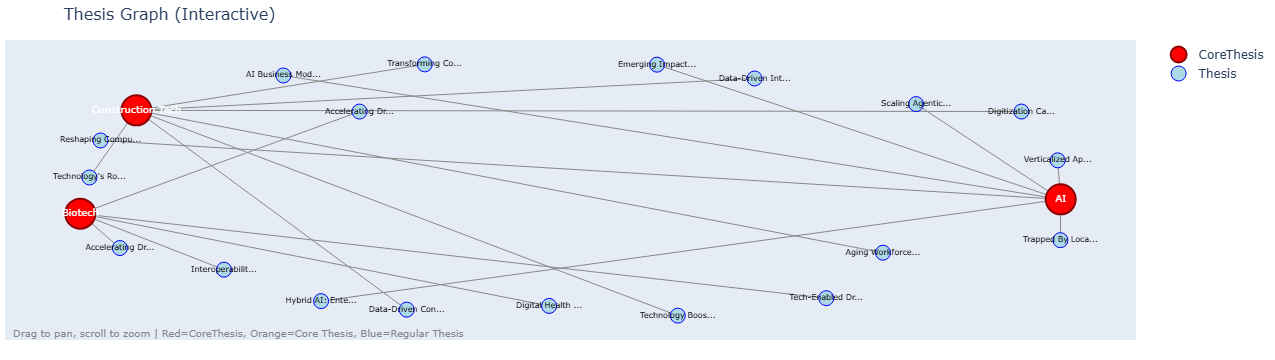

In [50]:
# Step 6: Interactive visualization using Plotly (optional, for better interactivity)

import plotly.graph_objects as go
import numpy as np

def visualize_graph_plotly(G: nx.DiGraph):
    """Create an interactive visualization using Plotly."""
    if G.number_of_nodes() == 0:
        print("⚠ No nodes to visualize")
        return
    
    # Use spring layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Prepare edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    # Only create edge trace if there are edges
    edge_trace = None
    if edge_x and edge_y:
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='#888'),
            hoverinfo='none',
            mode='lines',
            showlegend=False
        )
    
    # Prepare node traces by type
    node_traces = []
    
    # CoreThesis nodes (red, large)
    core_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "CoreThesis"]
    if core_nodes and len(core_nodes) > 0:
        node_x = [pos[n][0] for n in core_nodes]
        node_y = [pos[n][1] for n in core_nodes]
        node_labels = [n[:30] + "..." if len(n) > 30 else n for n in core_nodes]
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            name='CoreThesis',
            marker=dict(size=30, color='red', line=dict(width=2, color='darkred')),
            text=node_labels,
            textposition="middle center",
            textfont=dict(size=10, color="white"),
            hovertemplate='<b>%{text}</b><br>CoreThesis<extra></extra>'
        )
        node_traces.append(node_trace)
    
    # Core thesis nodes (orange, medium)
    core_thesis_nodes = [n for n, d in G.nodes(data=True) 
                        if d.get("node_type") == "Thesis" and d.get("is_core", False)]
    if core_thesis_nodes and len(core_thesis_nodes) > 0:
        node_x = [pos[n][0] for n in core_thesis_nodes]
        node_y = [pos[n][1] for n in core_thesis_nodes]
        # Use titles if available, otherwise use node numbers
        node_labels = []
        for n in core_thesis_nodes:
            title = G.nodes[n].get("title", "")
            if title:
                node_labels.append(title[:15] + "..." if len(title) > 15 else title)
            else:
                node_labels.append(f"#{G.nodes[n].get('node_num', '?')}")
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            name='Core Thesis',
            marker=dict(size=20, color='orange', line=dict(width=2, color='darkorange')),
            text=node_labels,
            textposition="middle center",
            textfont=dict(size=9, color="white"),
            hovertemplate='<b>%{text}</b><br>Core Thesis<extra></extra>'
        )
        node_traces.append(node_trace)
    
    # Regular thesis nodes (blue, small)
    regular_thesis = [n for n, d in G.nodes(data=True) 
                     if d.get("node_type") == "Thesis" and not d.get("is_core", False)]
    if regular_thesis and len(regular_thesis) > 0:
        node_x = [pos[n][0] for n in regular_thesis]
        node_y = [pos[n][1] for n in regular_thesis]
        # Use titles if available, otherwise use node numbers
        node_labels = []
        for n in regular_thesis:
            title = G.nodes[n].get("title", "")
            if title:
                node_labels.append(title[:15] + "..." if len(title) > 15 else title)
            else:
                node_labels.append(f"#{G.nodes[n].get('node_num', '?')}")
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            name='Thesis',
            marker=dict(size=15, color='lightblue', line=dict(width=1, color='blue')),
            text=node_labels,
            textposition="middle center",
            textfont=dict(size=8, color="black"),
            hovertemplate='<b>%{text}</b><br>Thesis<extra></extra>'
        )
        node_traces.append(node_trace)
    
    # Create figure data - only include edge_trace if it exists
    figure_data = node_traces
    if edge_trace:
        figure_data = [edge_trace] + node_traces
    
    # Create figure
    fig = go.Figure(
        data=figure_data,
        layout=go.Layout(
            title=dict(
                text='Thesis Graph (Interactive)',
                font=dict(size=16)
            ),
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=[dict(
                text="Drag to pan, scroll to zoom | Red=CoreThesis, Orange=Core Thesis, Blue=Regular Thesis",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002,
                xanchor="left", yanchor="bottom",
                font=dict(color="#888", size=10)
            )],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
    )
    
    fig.show()

# Create interactive visualization
if neo4j_driver:
    print("\n" + "="*60)
    print("INTERACTIVE VISUALIZATION")
    print("="*60)
    graph = query_neo4j_for_visualization(neo4j_driver)
    visualize_graph_plotly(graph)
else:
    print("⚠ Cannot visualize: Neo4j not connected")


## Neo4j Browser Visualization

**To visualize in Neo4j Browser:**

1. **Open Neo4j Browser:**
   - **Local Neo4j:** http://localhost:7474
   - **Neo4j Aura:** Check your Aura dashboard for the browser URL (usually similar to your connection URI but with port 7474)

2. **Login:**
   - Username: `neo4j` (or your configured username)
   - Password: Your Neo4j password

3. **Useful Cypher Queries:**

   **View all nodes:**
   ```cypher
   MATCH (n) RETURN n LIMIT 50
   ```

   **View thesis relationships:**
   ```cypher
   MATCH (t:Thesis)-[:SUPPORTS]->(ct:CoreThesis)
   RETURN t, ct
   LIMIT 50
   ```

   **View core theses:**
   ```cypher
   MATCH (t:Thesis {core_thesis: true})
   RETURN t
   ```

   **View a specific thesis and its connections:**
   ```cypher
   MATCH (t:Thesis)-[:SUPPORTS]->(ct:CoreThesis)
   WHERE t.node_num = 1
   RETURN t, ct
   ```

   **View the graph structure:**
   ```cypher
   MATCH path = (t:Thesis)-[:SUPPORTS]->(ct:CoreThesis)
   RETURN path
   LIMIT 25
   ```

   **Find theses supporting a specific core thesis:**
   ```cypher
   MATCH (t:Thesis)-[:SUPPORTS]->(ct:CoreThesis {core_thesis: "Your Core Thesis Value"})
   RETURN t, ct
   ```

   **Statistics query:**
   ```cypher
   MATCH (ct:CoreThesis)
   OPTIONAL MATCH (t:Thesis)-[:SUPPORTS]->(ct)
   RETURN ct.core_thesis as CoreThesis, 
          count(t) as SupportingTheses,
          collect(t.node_num)[0..10] as SampleThesisNumbers
   ORDER BY SupportingTheses DESC
   ```
